This notebook demonstrates extracting AEM conductivity data and gridding it using GDAL.

Neil Symington

neil.symington@ga.gov.au

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import netCDF4
import numpy as np
from geophys_utils._netcdf_line_utils import NetCDFLineUtils, NetCDFPointUtils
from hydrogeol_utils import spatial_functions
import fiona
import gdal
from shapely.geometry import Polygon, shape
import os
import gc
import math
import time
import tempfile
import affine
import rasterio

In [2]:
 # Import the AEM conductivity data
    

ncdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf'

# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdKeep2019_ModeExp_cor2DLogOrd.nc')
ek_cond = netCDF4.Dataset(cond_path)

In [3]:
ek_cond

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_east_min: 413602.8
    geospatial_east_max: 565524.1
    geospatial_east_units: m
    geospatial_north_min: 8244470.0
    geospatial_north_max: 8360774.0
    geospatial_north_units: m
    title: Dataset read from ASEG-GDF file OrdKeep2019_ModeExp_cor2DLogOrd.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: -28.13
    geospatial_vertical_max: 158.25
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file ..\combined_aseg_gdf\OrdKeep2019_ModeExp_cor2DLogOrd.dat using definitions file ..\combined_aseg_gdf\OrdKeep2019_ModeExp_cor2DLogOrd.dfn
    date_created: 2019-03-15T10:18:54.981470
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_bounds: POLYGON((128.7680 -15.8787, 128.7679 -15.8787, 128.7677 -15.8787, 1

In [4]:
# To utilise the geophys_utils for line data create a NetCDFLineUtils instance
cond_line_utils = NetCDFLineUtils(ek_cond)

cond_point_utils = NetCDFPointUtils(ek_cond)

# Display the lines for the conductivity mode
wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

In [5]:
wkt

'PROJCS["UTM Zone 52, Southern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'

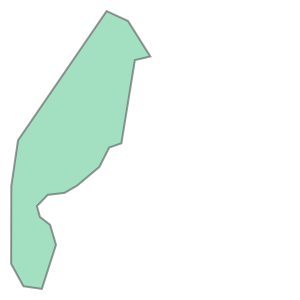

In [6]:
# WE are only going to grid lines that are within the Keep River plain area
# Open a polyon to use as a spatial mask

# Open geometry for a shapefile. This will be used to filter the bores extracted from the database
c = fiona.open(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\Keep_spatial\Keep_River_polygons.shp")
collection = [ shape(item['geometry']) for item in c ]
names = [item['properties']['Name'] for item in c]
polygons = [Polygon(pol.exterior.coords) for pol in collection] 

# Buffer by 5000 metres
OrdKeep = polygons[names.index('AEM_close')]

# Now keep only bores that are within 
OrdKeep

In [7]:
# Define gdal algorithm as string - see https://gdal.org/programs/gdal_grid.html
algorithm = 'invdist:power=2:radius1=250:radius2=250:max_points=15:'
algorithm += 'min_points=2:nodata=-32768.0'

grid_kwargs = {'conductivity': {'log_grid': True,
                                'gdal_algorithm': algorithm},
              'elevation': {'log_grid': False,
                                'gdal_algorithm': algorithm}}


grid = spatial_functions.grid_points_gdal(cond_point_utils, grid_resolution = 500.,
                 variables = ['conductivity','elevation'],
                 reprojected_grid_bounds = OrdKeep.bounds,
                 grid_wkt = wkt,
                 point_step=4, # Only use every 4th point
                 grid_kwargs = grid_kwargs)

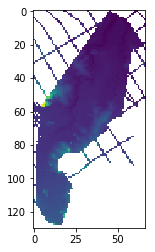

In [8]:

a = grid['elevation']
plt.imshow(np.flipud(a))
plt.show()

In [11]:
grid['geotransform']

(496000.0, 500.0, 0.0, 8261500.0, 0.0, 500.0)

In [9]:
# Create a muiltiband raster

outfile = r'C:\Temp\EK_AEM_conductivity_layer_slices.tiff'

arr = grid['conductivity']

aff = affine.Affine.from_gdal(*grid['geotransform'])

# Create a new dataset
new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height=arr.shape[1], width=arr.shape[2],
                                count=arr.shape[0], dtype=arr.dtype,
                                crs=grid['wkt'], transform=aff, nodata = np.nan)
for i in range(arr.shape[0]):
    new_dataset.write(arr[i], i+1)

new_dataset.close()

In [27]:
# Add to a netcdf4 grid file

nc_file = r'C:\Temp\EK_AEM_conductivity_layer_slices.nc'

# Find the coordinates for each dimension

arr = grid['conductivity']

x_coords = np.arange(grid['geotransform'][0],
                     arr.shape[2] *grid['geotransform'][1] + grid['geotransform'][0],
                     grid['geotransform'][1])

y_coords = np.arange(grid['geotransform'][3],
                     arr.shape[1] *grid['geotransform'][5] + grid['geotransform'][3],
                     grid['geotransform'][5])

layer_top_depth = ek_cond.variables['layer_top_depth'][0]

# Create dataset

nc_grid = netCDF4.Dataset(nc_file, "w", format="NETCDF4")

# Create dimensions

layer_top = nc_grid.createDimension('layer_top_depth', np.shape(layer_top_depth)[0])

x = nc_grid.createDimension('easting', np.shape(x_coords)[0])

y = nc_grid.createDimension('northing', np.shape(y_coords)[0])

# Create variables (both dimensions and variables)

xs = nc_grid.createVariable('easting', 'f4', ('easting'))

ys = nc_grid.createVariable('northing', 'f4', ('northing'))

layer_tops = nc_grid.createVariable('layer_top', 'f4', ('layer_top_depth'))

conductivity = nc_grid.createVariable('conductivity', 'f4', ('layer_top_depth',
                                                          'northing',
                                                          'easting'))
# Attribute the variables
nc_grid.description = "Layer grids from the nbc inversion of the 2017 SkyTEM East Kimberley AEM data"

nc_grid.history = "Created " + time.ctime(time.time())

nc_grid.source = "Produce in a Jupyter Notebook by Neil Symington (neil.symington@ga.gov.au)"

nc_grid.wkt = wkt

conductivity.units = "S/m"

xs.units = 'm'

ys.units = 'm'

layer_tops.units = 'mAHD'

# Write dimension data to variables
xs[:] = x_coords
ys[:] = y_coords
layer_tops[:] = layer_top_depth

# Write conductivity data to variables

conductivity[:] = arr

nc_grid.close()